# Programa de Ciencia de Datos, Aprendizaje Automático


**Tarea #4**

Estudiantes:

   - *Ricardo Montero Wille*

   - *Esteban Pérez Navarro*
   
   

**A continuación se presenta el desarrollo del problema:**

Primero se importan las librerías.

In [2]:
# Imports para tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange

# Imports para graficación
# ==============================================================================

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import sklearn.metrics as skm

# Imports para pre-procesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

#Esta línea se utiliza para evitar algunas advertencias que panda tiene
pd.options.mode.chained_assignment = None  # default='warn'

Seguidamente procedemos a leer el archivo y visualizamos las primeras 10 líneas. En este caso, vamos a utilizar un archivo que contiene datos relativos a una página de ventas digitales entre clientes, es decir, C2C (Customer To Customer). En esta, los usuarios pueden comprar y vender productos, y se cuenta con diferentes métricas para cada usuario, como su cantidad de seguidores, de seguidos, los productos listados y gustados, su país e idioma, entre otros. 

Dado que en la tarea pasada se utilizó el set de datos para predecir la cantidad de artículos que compra un usuario (problema de regresión), en este caso se decide darle un enfoque de clasificación, e intentar predecir si un usuario va a vender o comprar algo, o si no va a hacer ninguno de los dos. 

In [3]:
archivo = 'https://raw.githubusercontent.com/EstebanPN14/prueba2/main/ecommerce4.csv'
ecommerce = pd.read_csv(archivo,error_bad_lines=False)
ecommerce.head(10)

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,Indicador,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7.280000e+18,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1.460000e+18,user,Allemagne,de,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9.010000e+18,user,Suède,en,3,8,0,0,0,0.0,0,0,Bad User,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7.150000e+18,user,Turquie,en,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2.860000e+18,user,France,en,3,8,0,0,0,0.0,0,0,Bad User,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr
5,-8.370000e+18,user,Royaume-Uni,en,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,gb
6,-7.880000e+18,user,Royaume-Uni,en,3,8,4,0,0,0.0,0,0,Bad User,F,2,mrs,False,False,False,True,591,3205,106.83,8.9,gb
7,7.460000e+18,user,Italie,fr,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,True,True,False,True,709,3205,106.83,8.9,it
8,4.610000e+18,user,Italie,fr,3,8,0,0,0,0.0,0,0,Bad User,F,2,mrs,True,True,False,True,701,3205,106.83,8.9,it
9,-7.300000e+18,user,France,en,3,8,0,0,0,0.0,0,0,Bad User,M,1,mr,True,False,True,True,703,3205,106.83,8.9,fr


**Iniciando con el tratamiento y análisis exploratorio de los datos**

Seguidamente descartamos las columnas que no van a ser utilizadas por el modelo, por ser poco importantes según la investigación previa realizada (criterio experto) o que fueron reemplazadas por una nueva al hacer el label encoding. Para esto, se procede a usar la función drop.

In [4]:
porEliminar = []
#Removemos columnas que no aportan al modelo, segun criterio experto
porEliminar += ["identifierHash", "type", "civilityTitle", "countryCode","hasAnyApp","hasAndroidApp","hasIosApp","hasProfilePicture"]

#Removemos columnas duplicadas
porEliminar += ["seniority", "seniorityAsYears", "civilityGenderId"]

#Se remueven las columnas
ecommerce.drop(porEliminar, axis=1, errors='ignore', inplace=True)
ecommerce.head(9)

,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,Indicador,gender,daysSinceLastLogin,seniorityAsMonths
0,Etats-Unis,en,3,8,0,0,0,0.0,0,0,Bad User,F,709,106.83
1,Allemagne,de,3,8,0,0,0,0.0,0,0,Bad User,F,709,106.83
2,Suède,en,3,8,0,0,0,0.0,0,0,Bad User,M,689,106.83
3,Turquie,en,3,8,0,0,0,0.0,0,0,Bad User,F,709,106.83
4,France,en,3,8,0,0,0,0.0,0,0,Bad User,M,709,106.83
5,Royaume-Uni,en,3,8,0,0,0,0.0,0,0,Bad User,F,709,106.83
6,Royaume-Uni,en,3,8,4,0,0,0.0,0,0,Bad User,F,591,106.83
7,Italie,fr,3,8,0,0,0,0.0,0,0,Bad User,F,709,106.83
8,Italie,fr,3,8,0,0,0,0.0,0,0,Bad User,F,701,106.83


Se comienza a realizar el one hot encoding usando la columna de país. Dado que esta columna tiene alrededor de 180 países, se usa el método de solo codificar las 10 más frecuentes para transformarlas en columnas.

In [5]:
#Se buscan las mejores 20 categorías
ecommerce.country.value_counts().sort_values(ascending=False).head(20)

top_10 = [x for x in ecommerce.country.value_counts().sort_values(ascending=False).head(10).index]

#Se realiza un for que convierte cada una de ese top 10 en una columna y básicamente realiza el one hot encoding para esas 10
for label in top_10:
    ecommerce[label] = np.where(ecommerce["country"]==label,1,0)
ecommerce[["country"]+top_10].head(10)

,country,France,Etats-Unis,Royaume-Uni,Italie,Allemagne,Espagne,Australie,Danemark,Suède,Belgique
0,Etats-Unis,0,1,0,0,0,0,0,0,0,0
1,Allemagne,0,0,0,0,1,0,0,0,0,0
2,Suède,0,0,0,0,0,0,0,0,1,0
3,Turquie,0,0,0,0,0,0,0,0,0,0
4,France,1,0,0,0,0,0,0,0,0,0
5,Royaume-Uni,0,0,1,0,0,0,0,0,0,0
6,Royaume-Uni,0,0,1,0,0,0,0,0,0,0
7,Italie,0,0,0,1,0,0,0,0,0,0
8,Italie,0,0,0,1,0,0,0,0,0,0
9,France,1,0,0,0,0,0,0,0,0,0


Seguidamente se hace el one hot encoding de las variables de género e idioma.

In [6]:
# One-hot encoding 
ecommerce_procesado = pd.get_dummies(ecommerce, columns=['gender','language'])

ecommerce_procesado

,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,Indicador,daysSinceLastLogin,seniorityAsMonths,France,Etats-Unis,Royaume-Uni,Italie,Allemagne,Espagne,Australie,Danemark,Suède,Belgique,gender_F,gender_M,language_de,language_en,language_es,language_fr,language_it
0,Etats-Unis,3,8,0,0,0,0.0,0,0,Bad User,709,106.83,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,Allemagne,3,8,0,0,0,0.0,0,0,Bad User,709,106.83,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,Suède,3,8,0,0,0,0.0,0,0,Bad User,689,106.83,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
3,Turquie,3,8,0,0,0,0.0,0,0,Bad User,709,106.83,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,France,3,8,0,0,0,0.0,0,0,Bad User,709,106.83,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,Etats-Unis,3,8,0,0,0,0.0,0,0,Bad User,708,106.80,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
98909,France,3,8,0,0,0,0.0,0,0,Bad User,695,106.80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
98910,Belgique,3,8,0,0,0,0.0,0,0,Bad User,520,106.80,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
98911,Italie,3,8,0,0,0,0.0,0,0,Bad User,267,106.80,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


Se elimina el resto de columnas duplicadas. ProductsBought y ProductsSold se eliminan porque ya se toman en cuenta en la columna de indicador.

In [7]:
#Removemos columnas duplicadas
porEliminar += ["country","language","gender","productsBought","productsSold"]

#Se remueven las columnas
ecommerce_procesado.drop(porEliminar, axis=1, errors='ignore', inplace=True)

A continuación, se consulta el tipo de dato de cada columna, con el objetivo de determinar que son los necesarios para hacer un análisis cuantitativo. 

In [8]:
ecommerce_procesado.dtypes

socialNbFollowers        int64
socialNbFollows          int64
socialProductsLiked      int64
productsListed           int64
productsPassRate       float64
productsWished           int64
Indicador               object
daysSinceLastLogin       int64
seniorityAsMonths      float64
France                   int64
Etats-Unis               int64
Royaume-Uni              int64
Italie                   int64
Allemagne                int64
Espagne                  int64
Australie                int64
Danemark                 int64
Suède                    int64
Belgique                 int64
gender_F                 uint8
gender_M                 uint8
language_de              uint8
language_en              uint8
language_es              uint8
language_fr              uint8
language_it              uint8
dtype: object

Como parte de la limpieza de datos, se verifica que no existan nulos en el set, usando la función isna().

In [9]:
ecommerce_procesado.isna().sum()

socialNbFollowers      0
socialNbFollows        0
socialProductsLiked    0
productsListed         0
productsPassRate       0
productsWished         0
Indicador              0
daysSinceLastLogin     0
seniorityAsMonths      0
France                 0
Etats-Unis             0
Royaume-Uni            0
Italie                 0
Allemagne              0
Espagne                0
Australie              0
Danemark               0
Suède                  0
Belgique               0
gender_F               0
gender_M               0
language_de            0
language_en            0
language_es            0
language_fr            0
language_it            0
dtype: int64

Se procede a representar las correlaciones entre las diversas variables usando un mapa de calor. 

<function matplotlib.pyplot.show>

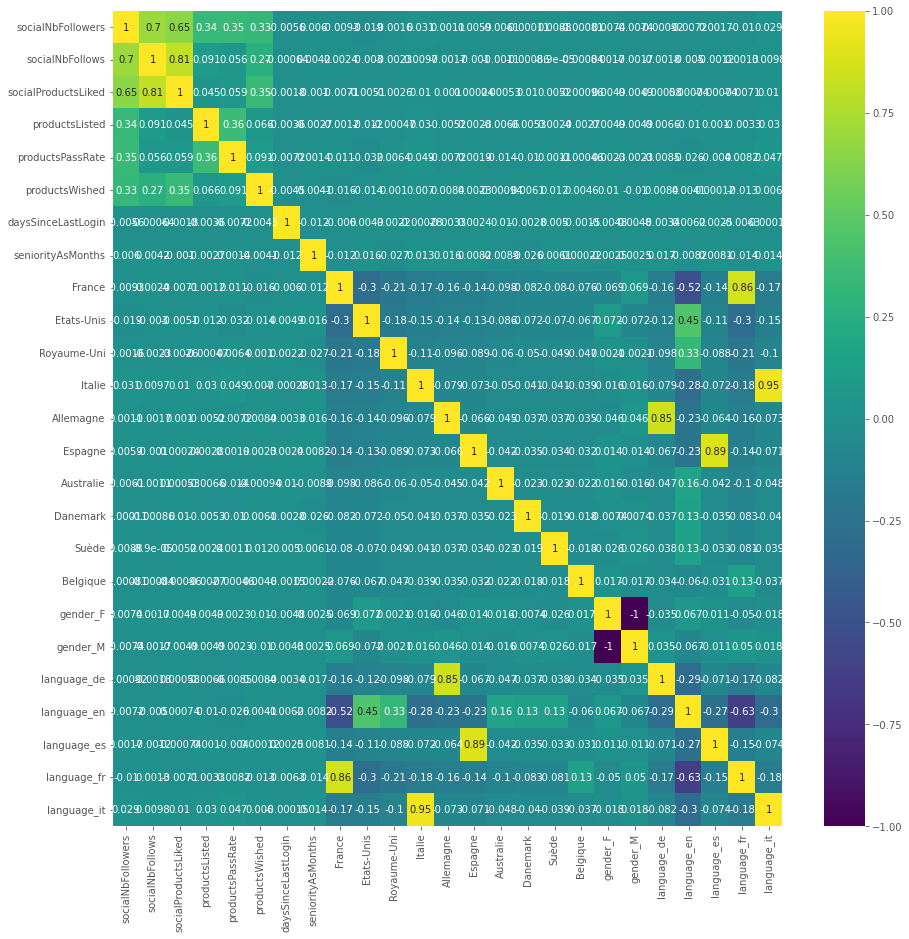

In [10]:
plt.figure(figsize=(15,15))

chart = sns.heatmap(ecommerce_procesado.corr(), annot = True, cmap = 'viridis')
plt.xticks(rotation=90)
plt.show

**Utilización del algoritmo genético**

Procedemos a dividir los datos en features y en la columna por predecir. Luego, se pasa la variable y a one hot encoding y se visualiza.

In [11]:
X = ecommerce_procesado.drop(columns='Indicador')
y = ecommerce_procesado['Indicador']

# One-hot encoding the y
y_procesado = pd.get_dummies(y, columns=['Indicador'])

y_procesado.head(4000)

,Bad User,Good User
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
3995,1,0
3996,1,0
3997,1,0
3998,0,1


Seguidamente, se normalizan los datos de X, para eliminar los posibles pesos que pueda tener una variable sobre otra por tema de escala. Se elige normalziar usando el MinMaxScaler que los pone en escala de 0 a 1, dado que en la investigación realizada se recomienda este método para redes neuronales.

Luego se pasan a arrays de numpy para que puedan ser alimentados a la red neuronal.

Finalmente, se imprime el tamaño de los arrays para ver que todo vaya correcto.

In [38]:
escalado = MinMaxScaler()
X_escalado = escalado.fit_transform(X)
X_escalado = pd.DataFrame(data = X_escalado, columns = X.columns)

X_nuevo = np.array(X_escalado)
y_nuevo = np.array(y_procesado)

#Verificando la entrada y la salida de los datos
print("Forma de X:", X_nuevo.shape)
print("\nForma de y:", y_nuevo.shape)


Forma de X: (13786, 25)

Forma de y: (98913, 2)


A continuación, se dividen los datos en entrenamiento y testeo, usando 70% para el entrenamiento y 30% para el testeo, lo cual está en el rango que la literatura recomienda.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y_nuevo, train_size= 0.7, random_state = 1234, shuffle = True)

In [14]:
print(y_train.shape)
print(X_train.shape)

print(y_test.shape)
print(X_test.shape)

(69239, 2)
(69239, 25)
(29674, 2)
(29674, 25)


Se importan los paquetes necesarios para la red.

In [15]:
# Imports para keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier


Construimos un modelo inicial con algunas funciones de activación, un optimizador cualquiera y una métrica para medir el desempeño del modelo

In [16]:

model = Sequential()

model.add(Dense(128, input_dim=25))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('sigmoid'))

model.add(Dense(2))
model.add(Activation('sigmoid'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3328      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 11,714
Trainable params: 11,714
Non-trainable params: 0
____________________________________________________

Se entrena el modelo con los hiperparámetros de epochs y batch definidos aleatoriamente.

In [17]:

model.fit(X_train, y_train, epochs=100, batch_size=40, verbose=0)


Se imprime la precisión del modelo, tanto para los datos de entrenamiento como para los de testeo.

In [18]:
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

2164/2164 [==============================] - 3s 1ms/step - loss: 0.2340 - accuracy: 0.9329

 Training Accuracy: 0.9328702092170715
928/928 [==============================] - 1s 1ms/step - loss: 0.2355 - accuracy: 0.9320

 Testing Accuracy: 0.9319943189620972


**Mejora del modelo usando hiperparámetros**

Se construye una función que permite ajustar el tamaño del batch y de epochs

In [ ]:
# Construimos el modelo para ajustar batch size y epochs
def create_model():
  mymodel = Sequential()
  mymodel.add(Dense(128, input_dim=25, activation='relu'))
  mymodel.add(Dense(2, activation='sigmoid'))

  mymodel.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return mymodel

model = KerasClassifier(build_fn=create_model)

Seguidamente se definen los parámetros para buscar usando el GridSearch y ajustandolo para que busque justamente estos hiperparámetros.

In [ ]:
# Definimos parámetros a ajustar
batchSize = [10, 20, 30, 40, 60, 80, 100, 150, 200]
epochs = [50, 100, 200]

parameter_grid = dict(batch_size = batchSize, epochs = epochs)

mygrid = GridSearchCV(estimator = model, param_grid = parameter_grid, n_jobs= -1, cv = 3)
grid_result = mygrid.fit(X_train, y_train)

Epoch 1/200
866/866 [==============================] - 2s 2ms/step - loss: 0.2475 - accuracy: 0.9347
Epoch 2/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2219 - accuracy: 0.9399
Epoch 3/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2174 - accuracy: 0.9403
Epoch 4/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2126 - accuracy: 0.9407
Epoch 5/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2077 - accuracy: 0.9410
Epoch 6/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2034 - accuracy: 0.9417
Epoch 7/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1998 - accuracy: 0.9422
Epoch 8/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1964 - accuracy: 0.9427
Epoch 9/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1939 - accuracy: 0.9431
Epoch 10/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1921 - accura

In [ ]:
print("El mejor es: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

El mejor es: 0.946475 usando {'batch_size': 80, 'epochs': 200}


Se denota que con un tamaño de batch de 80 y 200 epochs el modelo aumenta su precisión en un 1%.

Nuestro objetivo ahora es ajustar el optimizador usando para mejorar todavía el modelo

In [ ]:

def create_my_model(optimizer='adam'):
  mymodel = Sequential()
  mymodel.add(Dense(128, input_dim=25, activation='relu'))
 
  mymodel.add(Dense(2, activation='sigmoid'))

  mymodel.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return mymodel

model = KerasClassifier(build_fn=create_my_model, epochs=200, batch_size=80)

Se definen los modelos que se van a probar para el optimizar usando el GridSearch.

In [ ]:
# Definimos los parámetroa a ajustar
optimizer = ['SGD' , 'Adadelta', 'RMSprop', 'Adagrad', 'Adam']
parameter_grid = dict(optimizer=optimizer)

Se corre el GridSearch para buscar el mejor optimizador para el modelo.

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = parameter_grid, n_jobs= -1, cv = 3)
grid_result = grid.fit(X_train, y_train)

Epoch 1/200
866/866 [==============================] - 2s 2ms/step - loss: 0.2530 - accuracy: 0.9257
Epoch 2/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2219 - accuracy: 0.9399
Epoch 3/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2175 - accuracy: 0.9402
Epoch 4/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2124 - accuracy: 0.9407
Epoch 5/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2075 - accuracy: 0.9410
Epoch 6/200
866/866 [==============================] - 1s 2ms/step - loss: 0.2026 - accuracy: 0.9417
Epoch 7/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1990 - accuracy: 0.9424
Epoch 8/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1956 - accuracy: 0.9427
Epoch 9/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1931 - accuracy: 0.9432
Epoch 10/200
866/866 [==============================] - 1s 2ms/step - loss: 0.1906 - accura

In [ ]:
print("El mejor es: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

El mejor es: 0.946519 usando {'optimizer': 'Adam'}


Con esto nos damos cuenta que el optimizador que se debe utilizar es el Adam.
Seguidamente procedemos a correr un nuevo modelo pero los hiperparámetros encontrados como mejores.

In [19]:
modelo = Sequential()

modelo.add(Dense(128, input_dim=25))
modelo.add(Activation('relu'))
modelo.add(Dense(2))
modelo.add(Activation('sigmoid'))

# Compiling the model
modelo.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               3328      
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
Total params: 3,586
Trainable params: 3,586
Non-trainable params: 0
_________________________________________________________________



Entrenamos el modelo con el nuevo batch size y los epochs encontrados en la optimización con GridSearch.



In [20]:

modelo.fit(X_train, y_train, epochs=200, batch_size=80, verbose=0)


Corremos el modelo y se encientra que la precisión del testeo aumenta prácticamente en un 1% con respecto al inicial, por lo que se considera que la búsqueda de los mejores hiperparámetros fue exitosa.

In [21]:
# Evaluamos el modelo en el set de entrenamiento y prueba
score = modelo.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = modelo.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

2164/2164 [==============================] - 3s 1ms/step - loss: 0.1494 - accuracy: 0.9481

 Training Accuracy: 0.9480928182601929
928/928 [==============================] - 1s 1ms/step - loss: 0.1534 - accuracy: 0.9468

 Testing Accuracy: 0.9467547535896301


**¨Modelo tomando en cuenta el sesgo que existe cuando una clase tiene muchos más registros que la otra**

Al revisar en la literatura, se encuentra que existe un sesgo en los modelos de aprendizaje automático y de redes neuronales el cual se da cuando existe una gran cantidad de datos de una de las clases que se quiere clasificar, y de la otra existen pocos registros. Esto origina que el modelo siempre los clasifique todos como la clase predominante, inflando la precisión pero de forma inadecuada. Para esto, se procede a realizar el siguiente análisis. 

Primero, realizamos un histograma para ver si efectivamente existe una gran diferencia entre la cantidad de registros que tiene cada clase.

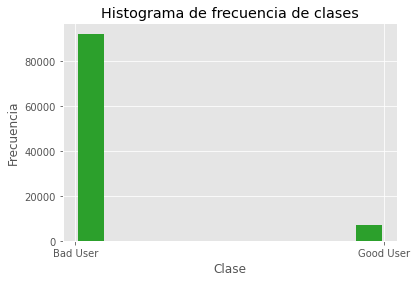

In [22]:
plt.hist(y, color = '#2ca02c', rwidth=0.85)
plt.title('Histograma de frecuencia de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')


plt.show() 


Ya aquí se denota que el fenómeno descrito anteriormente está pasando, y que es necesario hacer algo al respecto. Al revisar la teoría, se encuentra que una de las formas para arreglar este sesgo es reducir la cantidad de datos de la clase predominante para que sea igual a la otra. Este es el procedimiento que se va a realizar en este caso.

Primero, generamos dos dataframes, uno con los datos de cada clase, y vemos cuál es la cantidad de registros para cada uno

In [23]:
buenos_usuarios = ecommerce_procesado.loc[ecommerce_procesado['Indicador'] == 'Good User']
malos_usuarios = ecommerce_procesado.loc[ecommerce_procesado['Indicador'] == 'Bad User']

print("Cantidad de buenos usuarios: ",buenos_usuarios.shape[0])
print("Cantidad de malos usuarios: ",malos_usuarios.shape[0])

Cantidad de buenos usuarios:  6893
Cantidad de malos usuarios:  92020


Ahora procedemos a solamente dejarnos los primeros 6893 registros de la clase dominante, para que así ambas tengan el mismo tamaño.

In [24]:
malos_usuarios_filtrado = malos_usuarios.head(6893)

Ahora concatenamos los dos dataframes, obteniendo uno solo con los registros del mismo tamaño para ambas clases.

In [26]:
ecommerce_nuevo = pd.concat([buenos_usuarios,malos_usuarios_filtrado])

Importamos la función shuffle para que no queden todos los registros de las mismas clases juntos.

In [27]:
from sklearn.utils import shuffle

ecommerce_revuelto = shuffle(ecommerce_nuevo)

Nuevamente realizamos todo el tratamiento y limpieza de datos pero para el nuevo dataframe que tiene las clases con las mismas cantidades

In [30]:
X = ecommerce_revuelto.drop(columns='Indicador')
y = ecommerce_revuelto['Indicador']


y_revuelto = pd.get_dummies(y, columns=['Indicador'])
y_revuelto.head(20)

,Bad User,Good User
42304,0,1
40841,0,1
2453,0,1
89232,0,1
2333,1,0
4331,1,0
2520,1,0
84870,0,1
7250,1,0
482,1,0


In [31]:
escalado = MinMaxScaler()
X_escalado = escalado.fit_transform(X)
X_escalado = pd.DataFrame(data = X_escalado, columns = X.columns)

Se verifica que el tamaño de X y de y sean los correctos

In [33]:
X_nuevo = np.array(X_escalado)
y_nuevo = np.array(y_revuelto)

#Verificando la entrada y la salida de los datos
print("Forma de X:", X_nuevo.shape)
print("\nForma de y:", y_nuevo.shape)


Forma de X: (13786, 25)

Forma de y: (13786, 2)


Se parten nuevamente en entrenamiento y testing, usando el 70%

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y_nuevo, train_size= 0.7, random_state = 1234, shuffle = True)

Vamos a definir la red con los hiperparámetros que nos dimos cuenta que eran los mejores, usando el optimizador Adam, el tamaño del batch de 80 y 200 epochs.

In [35]:
modelo = Sequential()

modelo.add(Dense(128, input_dim=25))
modelo.add(Activation('relu'))
modelo.add(Dense(2))
modelo.add(Activation('sigmoid'))

# Compiling the model
modelo.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               3328      
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 3,586
Trainable params: 3,586
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Se entrena el modelo
modelo.fit(X_train, y_train, epochs=200, batch_size=80, verbose=0)

Finalmente, se evalúa el modelo en sus ambos sets.

In [37]:
# Evaluamos el modelo en el set de entrenamiento y prueba
score = modelo.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = modelo.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1])

302/302 [==============================] - 0s 1ms/step - loss: 0.2587 - accuracy: 0.8983

 Training Accuracy: 0.898341953754425
130/130 [==============================] - 0s 1ms/step - loss: 0.2803 - accuracy: 0.8934

 Testing Accuracy: 0.8933752179145813


Queda evidenciado que al reducir el número de registros de 98.000 a solamente 13.000 se pierde un poco de precisión en el modelo, sin embargo, 89.34% sigue siendo una buena capacidad predictiva. Además, este es un sacrificio necesario, por el hecho de que si se dejaban todos los 98.000 datos podía existir el sesgo de clase, producto de la dominancia de los malos clientes. De esta manera, nos aseguramos que el modelo es correcto y que cuenta con buena capacidad de predecir. 